<a href="https://colab.research.google.com/github/HakimSkaik/Autonomous-Car/blob/main/Traffic_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

from keras.callbacks import LearningRateScheduler, ModelCheckpoint


In [ ]:
%matplotlib inline
np.random.seed(0)

In [ ]:
#load data

with open('german-traffic-signs/train.p', 'rb') as f:
  train_data= pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data= pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data= pickle.load(f)

print(type(train_data))

# Seperate features and labels 

X_train, y_train= train_data['features'], train_data['labels']
X_val, y_val= val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

  

<class 'dict'>


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)



(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."


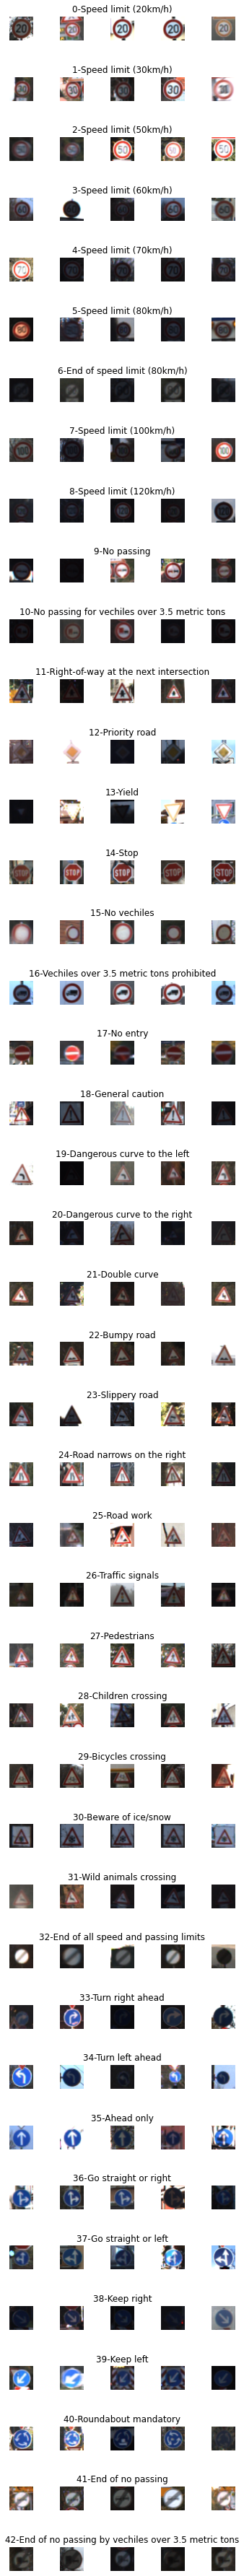

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples= []


cols=5
num_classes=43

fig, axs= plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected= X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i==2:
      axs[j][i].set_title(str(j)+ "-"+ row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


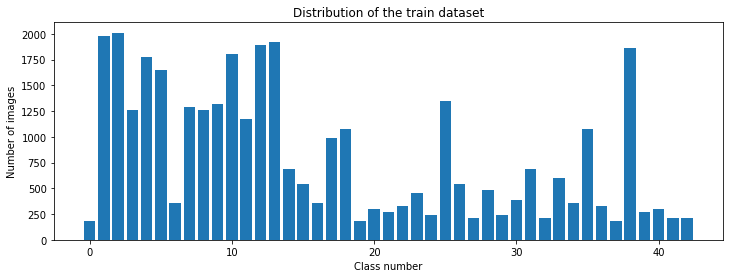

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


(32, 32, 3)
36 Class name


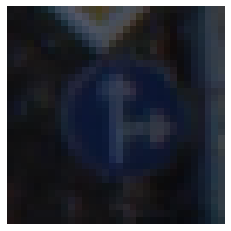

In [ ]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000], "Class name")

(32, 32)


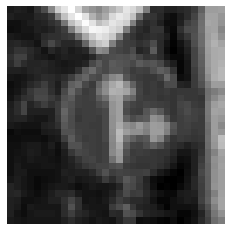

In [ ]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
 
img = grayscale(X_train[1000])
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

(32, 32)


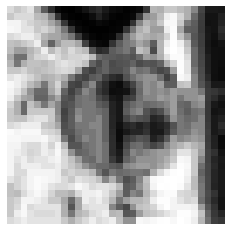

In [ ]:
def equalize(img):
  img= cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap("Greys"))
plt.axis("off")  
print(img.shape)

In [ ]:
def preprocessing(img):
  img= grayscale(img)
  img= equalize(img)
  img = img/255
  return img

X_train= np.array(list(map(preprocessing, X_train)))
X_test= np.array(list(map(preprocessing, X_test)))
X_val= np.array(list(map(preprocessing, X_val)))  
  


(34799, 32, 32)


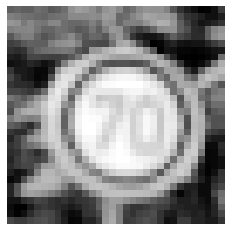

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train)- 1)], cmap=plt.get_cmap("gray"))

plt.axis("off")
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test= X_test.reshape(12630, 32, 32, 1)
X_val= X_val.reshape(4410, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)                   

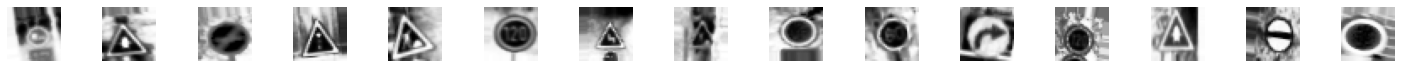

In [ ]:
batches= datagen.flow(X_train, y_train, batch_size=15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32), cmap=plt.get_cmap("Greys"))
  axs[i].axis('off')

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)



(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32, 32, 1), activation='relu')) #780 adjustable parameters
  model.add(Conv2D(60, (5,5), activation='relu')) 
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3,3), activation='relu')) #4065 parameters
  model.add(Conv2D(30, (3,3), activation='relu')) 
  model.add(MaxPooling2D(pool_size=(2,2))) #14 x 14 rather than 28 x 28
  # model.add(Dropout(0.5))


  model.add(Flatten())
  model.add(Dense(500, activation= 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation = 'softmax'))
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = modified_model()
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_85 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_87 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=695,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


695/695 [==============================] - 15s 21ms/step - loss: 1.8281 - accuracy: 0.4813 - val_loss: 0.2664 - val_accuracy: 0.9186
Epoch 2/10
695/695 [==============================] - 14s 21ms/step - loss: 0.4761 - accuracy: 0.8533 - val_loss: 0.1180 - val_accuracy: 0.9673
Epoch 3/10
695/695 [==============================] - 15s 21ms/step - loss: 0.2890 - accuracy: 0.9102 - val_loss: 0.0680 - val_accuracy: 0.9823
Epoch 4/10
695/695 [==============================] - 15s 22ms/step - loss: 0.2122 - accuracy: 0.9327 - val_loss: 0.0575 - val_accuracy: 0.9834
Epoch 5/10
695/695 [==============================] - 14s 21ms/step - loss: 0.1707 - accuracy: 0.9460 - val_loss: 0.0469 - val_accuracy: 0.9893
Epoch 6/10
695/695 [==============================] - 14s 21ms/step - loss: 0.1517 - accuracy: 0.9541 - val_loss: 0.0705 - val_accuracy: 0.9821
Epoch 7/10
695/695 [==============================] - 14s 21ms/step - loss: 0.1325 - accuracy: 0.9595 - val_loss: 0.0360 - val_accuracy: 0.9923
Epo

Text(0.5, 0, 'epoch')

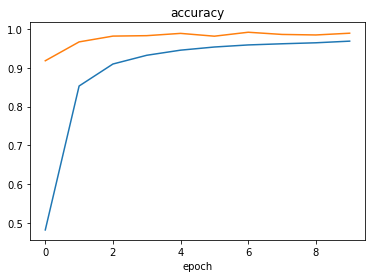

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

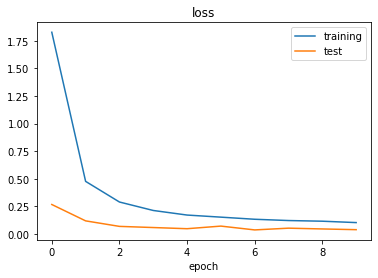

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','test'])
plt.title('loss')
plt.xlabel('epoch')

In [ ]:
score= model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.1183190792798996
Test accuracy: 0.9719715118408203


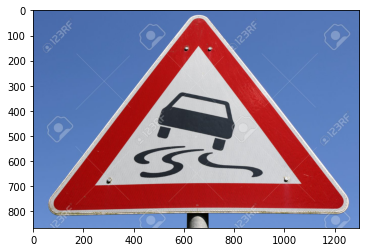

In [ ]:
#fetch image
 
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


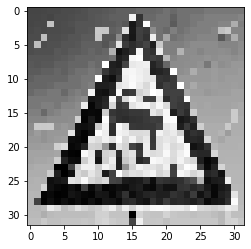

In [ ]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)

In [ ]:
#Test image
pred = np.argmax(model.predict(img), axis =-1)
print("Predicted sign: " + str(pred))

1/1 [==============================] - 0s 70ms/step
Predicted sign: [23]
